<a href="https://colab.research.google.com/github/albertaillet/CLIPLSD/blob/colab-setup/notebooks/experiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup
Restart the runtime after running this.

* Clone repo and from correct branch

* Download the pretrained stylegan2 model from https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/

* Install requirements

* Update github repo

In [2]:
import os
if "CLIPLSD" not in os.getcwd():
  if "CLIPLSD" not in os.listdir('.'):
    !git clone --branch colab-setup https://github.com/albertaillet/CLIPLSD/
    !wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl -P pretrained/stylegan2
    !gdown --id 154JgKpzCPW82qINcVieuPH3fZ2e0P812 -O CLIPLSD/pretrained/face_bisenet/model.pth
    !pip install git+https://github.com/openai/CLIP.git
    !pip install -r CLIPLSD/requirements.txt
    !!npm install -g localtunnel
  %cd CLIPLSD/
%ls

/content/CLIPLSD
apps/       environment.yml  LICENSE     out/          readme.md
cliplsd.py  images/          models/     pretrained/   requirements.txt
Dockerfile  lelsd.py         notebooks/  __pycache__/  utils/


In [7]:
!update-alternatives --list python3

/usr/bin/python3.6
/usr/bin/python3.7


In [5]:
!pip install -r CLIPLSD/requirements.txt

ERROR: Could not find a version that satisfies the requirement python_version>=3.8.0 (from -r CLIPLSD/requirements.txt (line 1)) (from versions: 0.0.2)
ERROR: No matching distribution found for python_version>=3.8.0 (from -r CLIPLSD/requirements.txt (line 1))


In [11]:
!sudo update-alternatives --config python3

There are 2 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                Priority   Status
------------------------------------------------------------
  0            /usr/bin/python3.7   2         auto mode
  1            /usr/bin/python3.6   1         manual mode
* 2            /usr/bin/python3.7   2         manual mode

Press <enter> to keep the current choice[*], or type selection number: 1
update-alternatives: using /usr/bin/python3.6 to provide /usr/bin/python3 (python3) in manual mode


In [17]:
!sudo update-alternatives --config python3

There are 2 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                Priority   Status
------------------------------------------------------------
  0            /usr/bin/python3.7   2         auto mode
* 1            /usr/bin/python3.6   1         manual mode
  2            /usr/bin/python3.7   2         manual mode

Press <enter> to keep the current choice[*], or type selection number: ^C


In [ ]:
sys.version

In [1]:
help('modules')


Please wait a moment while I gather a list of all available modules...



/usr/local/lib/python2.7/dist-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
W0519 15:11:31.869653 140363246344064 logger.py:222] AstropyDeprecationWarning: The astropy.vo.samp module has now been moved to astropy.samp
/usr/local/lib/python2.7/dist-packages/psycopg2/__init__.py:144: UserWarning:

The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.

/usr/local/lib/python2.7/dist-packages/folium/__init__.py:59: UserWarning:

This version of folium is the last to support Python 2. Transition to Python 3 to be able to receive updates and fixes. Check out https://python3statement.org/ for more info.




Failed to import TensorFlow. Please note that TensorFlow is not installed by default when you install Gin-Config. This is so that users can decide whether to install the GPU-enabled TensorFlow package. To use Gin-Config, please install the most recent version of TensorFlow, by following instructions at https://tensorflow.org/install.




In [12]:
!python3 --version

Python 3.6.9


In [3]:
!git status

On branch colab-setup
Your branch is up to date with 'origin/colab-setup'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   apps/1D_visualization.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	pretrained/arcface/
	pretrained/face_bisenet/model.pth
	pretrained/face_bisenet/models.zip
	pretrained/stylegan2/ffhq.pkl

no changes added to commit (use "git add" and/or "git commit -a")


In [5]:
!git checkout apps/1D_visualization.py

In [7]:
!git pull

Already up to date.


# Imports

In [ ]:
#%load_ext autoreload
#%autoreload 2

import warnings
warnings.filterwarnings("ignore")
import sys
import torch

import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython.display import Image 

import clip
import models
from utils.stylegan2_utils import StyleGAN2SampleGenerator

# CLIP

In [ ]:
", ".join(clip.available_models())

'RN50, RN101, RN50x4, RN50x16, RN50x64, ViT-B/32, ViT-B/16, ViT-L/14'

In [ ]:
device = torch.device('cuda')

exp_dir = "out"
G2 = models.get_model("stylegan2", "pretrained/stylegan2/ffhq.pkl")
sample_generator = StyleGAN2SampleGenerator(G=G2, device=device)
clip_model, preprocess = clip.load("ViT-B/32")
_ = clip_model.cuda().eval()

In [ ]:
def get_similarity(original_images, texts):
  
  images = [preprocess(img) for img in original_images]
  image_input = torch.tensor(np.stack(images)).cuda()
  
  text_tokens = clip.tokenize(texts).cuda()

  with torch.no_grad():
    image_features = clip_model.encode_image(image_input).float()
    text_features = clip_model.encode_text(text_tokens).float()
  
  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)

  similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

  plt.figure(figsize=(20, 15))
  plt.imshow(similarity, vmin=0.1, vmax=0.3)
  plt.yticks(range(len(texts)), texts, fontsize=18)
  plt.xticks([])
  for i, image in enumerate(original_images):
      plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.5, -0.5), origin="lower", )
  for x in range(similarity.shape[1]):
      for y in range(similarity.shape[0]):
          plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

  for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

  plt.xlim([-0.5, batch_size - 0.5])
  plt.ylim([len(texts) + 0.5, -2])

  return plt.title("Cosine similarity between text and image features", size=20)

tested seeds: 1, 2, 4, 6, 7

Very good: "earrings", "a white hat", "glasses", "a hat", "curly hair"¨

Ok but not super: "black eyes", "green eyes", "gray hair", "grey hair", "a smile",  "blue eyes"

Not that good: "long hair", "short hair"

Text(0.5, 1.0, 'Cosine similarity between text and image features')

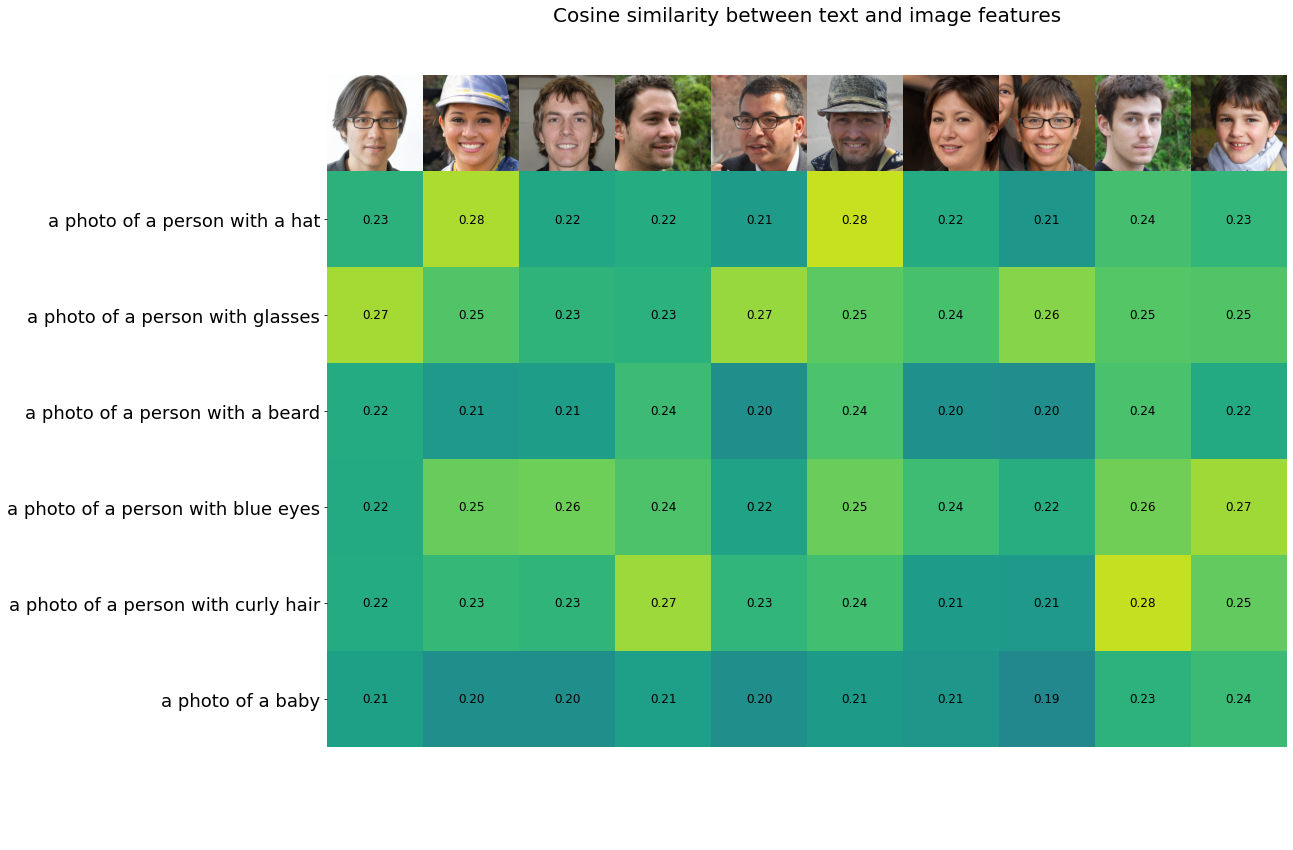

In [ ]:
seed = 2
batch_size = 10
batch_data = sample_generator.generate_batch(seed, return_image=True, 
                                             batch_size=batch_size, 
                                             return_style=False)

descs = ["a hat", "glasses", "a beard", "curly hair"] 

texts = ["a photo of a person with " + desc for desc in descs]
texts.append("a photo of a baby")
#texts.append("a photo of a person on a blue background")

get_similarity(batch_data["image"], texts)

In [ ]:
batch_data["image"][3]

In [ ]:
ws = batch_data["ws"]
ws[:, 1, :] += 1

Text(0.5, 1.0, 'Cosine similarity between text and image features')

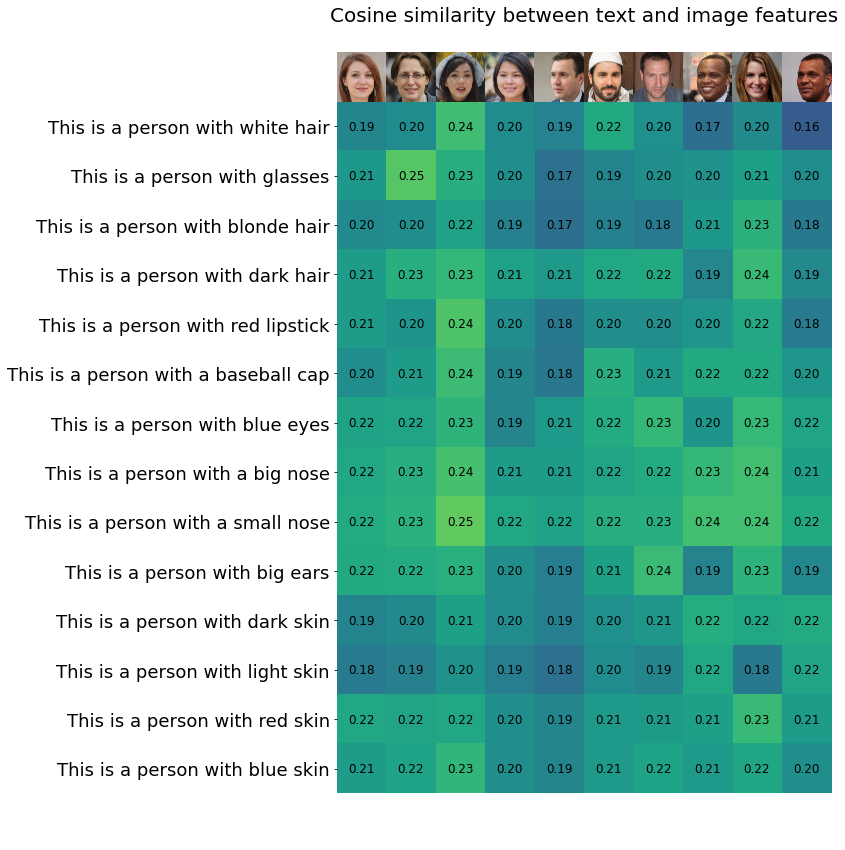

In [ ]:
new_batch_data = sample_generator.generate_batch_from_ws(ws, return_image=True)
descs = ["white hair", "glasses", "blonde hair", "dark hair", "red lipstick", "a baseball cap", "blue eyes", "a big nose", "a small nose", "big ears", "dark skin", "light skin", "red skin", "blue skin"]
get_similarity(new_batch_data["image"], descs)

# Stylegan 1 classifiers

[link](https://github.com/NVlabs/stylegan/blob/master/metrics/linear_separability.py)

In [23]:
classifier_ids = {
    '1Q5-AI6TwWhCVM7Muu4tBM7rp5nG_gmCX': 'celebahq-classifier-00-male.pkl',
    '1Q5c6HE__ReW2W8qYAXpao68V1ryuisGo': 'celebahq-classifier-01-smiling.pkl',
    '1Q7738mgWTljPOJQrZtSMLxzShEhrvVsU': 'celebahq-classifier-02-attractive.pkl',
    '1QBv2Mxe7ZLvOv1YBTLq-T4DS3HjmXV0o': 'celebahq-classifier-03-wavy-hair.pkl',
    '1QIvKTrkYpUrdA45nf7pspwAqXDwWOLhV': 'celebahq-classifier-04-young.pkl',
    '1QJPH5rW7MbIjFUdZT7vRYfyUjNYDl4_L': 'celebahq-classifier-05-5-o-clock-shadow.pkl',
    '1QPZXSYf6cptQnApWS_T83sqFMun3rULY': 'celebahq-classifier-06-arched-eyebrows.pkl',
    '1QPgoAZRqINXk_PFoQ6NwMmiJfxc5d2Pg': 'celebahq-classifier-07-bags-under-eyes.pkl',
    '1QQPQgxgI6wrMWNyxFyTLSgMVZmRr1oO7': 'celebahq-classifier-08-bald.pkl',
    '1QcSphAmV62UrCIqhMGgcIlZfoe8hfWaF': 'celebahq-classifier-09-bangs.pkl',
    '1QdWTVwljClTFrrrcZnPuPOR4mEuz7jGh': 'celebahq-classifier-10-big-lips.pkl',
    '1QgvEWEtr2mS4yj1b_Y3WKe6cLWL3LYmK': 'celebahq-classifier-11-big-nose.pkl',
    '1QidfMk9FOKgmUUIziTCeo8t-kTGwcT18': 'celebahq-classifier-12-black-hair.pkl',
    '1QthrJt-wY31GPtV8SbnZQZ0_UEdhasHO': 'celebahq-classifier-13-blond-hair.pkl',
    '1QvCAkXxdYT4sIwCzYDnCL9Nb5TDYUxGW': 'celebahq-classifier-14-blurry.pkl',
    '1QvLWuwSuWI9Ln8cpxSGHIciUsnmaw8L0': 'celebahq-classifier-15-brown-hair.pkl',
    '1QxW6THPI2fqDoiFEMaV6pWWHhKI_OoA7': 'celebahq-classifier-16-bushy-eyebrows.pkl',
    '1R71xKw8oTW2IHyqmRDChhTBkW9wq4N9v': 'celebahq-classifier-17-chubby.pkl',
    '1RDn_fiLfEGbTc7JjazRXuAxJpr-4Pl67': 'celebahq-classifier-18-double-chin.pkl',
    '1RGBuwXbaz5052bM4VFvaSJaqNvVM4_cI': 'celebahq-classifier-19-eyeglasses.pkl',
    '1RIxOiWxDpUwhB-9HzDkbkLegkd7euRU9': 'celebahq-classifier-20-goatee.pkl',
    '1RPaNiEnJODdr-fwXhUFdoSQLFFZC7rC-': 'celebahq-classifier-21-gray-hair.pkl',
    '1RQH8lPSwOI2K_9XQCZ2Ktz7xm46o80ep': 'celebahq-classifier-22-heavy-makeup.pkl',
    '1RXZM61xCzlwUZKq-X7QhxOg0D2telPow': 'celebahq-classifier-23-high-cheekbones.pkl',
    '1RgASVHW8EWMyOCiRb5fsUijFu-HfxONM': 'celebahq-classifier-24-mouth-slightly-open.pkl',
    '1RkC8JLqLosWMaRne3DARRgolhbtg_wnr': 'celebahq-classifier-25-mustache.pkl',
    '1RqtbtFT2EuwpGTqsTYJDyXdnDsFCPtLO': 'celebahq-classifier-26-narrow-eyes.pkl',
    '1Rs7hU-re8bBMeRHR-fKgMbjPh-RIbrsh': 'celebahq-classifier-27-no-beard.pkl',
    '1RynDJQWdGOAGffmkPVCrLJqy_fciPF9E': 'celebahq-classifier-28-oval-face.pkl',
    '1S0TZ_Hdv5cb06NDaCD8NqVfKy7MuXZsN': 'celebahq-classifier-29-pale-skin.pkl',
    '1S3JPhZH2B4gVZZYCWkxoRP11q09PjCkA': 'celebahq-classifier-30-pointy-nose.pkl',
    '1S3pQuUz-Jiywq_euhsfezWfGkfzLZ87W': 'celebahq-classifier-31-receding-hairline.pkl',
    '1S6nyIl_SEI3M4l748xEdTV2vymB_-lrY': 'celebahq-classifier-32-rosy-cheeks.pkl',
    '1S9P5WCi3GYIBPVYiPTWygrYIUSIKGxbU': 'celebahq-classifier-33-sideburns.pkl',
    '1SANviG-pp08n7AFpE9wrARzozPIlbfCH': 'celebahq-classifier-34-straight-hair.pkl',
    '1SArgyMl6_z7P7coAuArqUC2zbmckecEY': 'celebahq-classifier-35-wearing-earrings.pkl',
    '1SC5JjS5J-J4zXFO9Vk2ZU2DT82TZUza_': 'celebahq-classifier-36-wearing-hat.pkl',
    '1SDAQWz03HGiu0MSOKyn7gvrp3wdIGoj-': 'celebahq-classifier-37-wearing-lipstick.pkl',
    '1SEtrVK-TQUC0XeGkBE9y7L8VXfbchyKX': 'celebahq-classifier-38-wearing-necklace.pkl',
    '1SF_mJIdyGINXoV-I6IAxHB_k5dxiF6M-': 'celebahq-classifier-39-wearing-necktie.pkl',
}

In [27]:
for id, name in classifier_ids.items():
  !gdown --id $id -O pretrained/classifiers/$name

('1SEtrVK-TQUC0XeGkBE9y7L8VXfbchyKX', 'celebahq-classifier-38-wearing-necklace.pkl')


In [ ]:
!pip install pickle==

In [1]:
!python --version

Python 2.7.17


In [33]:
import pickle
with open('pretrained/classifiers/celebahq-classifier-00-male.pkl', 'rb') as f:
  p = pickle.load(f)

print(p)

ValueError: ignored

In [18]:
classifier_ids[0]

'1Q5-AI6TwWhCVM7Muu4tBM7rp5nG_gmCX'